# Project Setup

In [48]:
# Load Necessary Packages

# Base modules
import pandas as pd 
import numpy as np

# API Modules
import requests
import time
import os
from tqdm import tqdm 

# Plotting
from PIL import Image
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Project Topic

### Project Explanation

 This projct is a supervised machine learning project. I will be classifying photos of wildlife as their species. 

### Project Goal

This project aims to identify the species of animals from iNaturalist data. 

I find this topic interesting as I often venture into the outdoors and encounter lots of different wildlife. Additionally, this classification could be used for conservationists and wildlife biologist to track animals and get an understanding of population health. 

I aim to hone my skills in machine learning, feature engineering, and hyperparamter tuning throughout this project.

# Data

The data I used for this project was acquired through iNaturalist, a wildlife observation website: https://www.inaturalist.org/pages/api+reference. 

##### Set Parameters of the API Calls

In [3]:
# Set the location
location=34 # This is colorado


# Dictionary of taxon IDs
taxon_id_dict = {'yellow_bellied_marmot': 46086,
                   'red_tail_hawk': 5212} 


taxon_list = globals()["taxon_id_dict"]
taxon_list['yellow_bellied_marmot']

46086

In [4]:
# Parameters for the API Call
params = {
    "per_page": 200,          
    "page": 1 
}

##### Make API calls to get images of each species

See this link for help building the URL: https://api.inaturalist.org/v1/docs/#!/Observations/get_observations_observers

In [5]:
# Create an empty data frame to store the data
species_df = pd.DataFrame()

# Clean the taxon name for the URL
for taxon_name in taxon_list:

    taxon_id=taxon_list[taxon_name]

    # Base URL for given species and location
    base_url = f"https://api.inaturalist.org/v1/observations?captive=false&photos=true&quality_grade=research&place_id={location}&taxon_id={taxon_id}"

    # Create a list to store all results
    observations = []

    # Loop through pages
    while True:
        
        # Get the response
        response = requests.get(base_url, params=params)
        if response.status_code != 200:
            print("Error:", response.status_code)
            break
        
        # Get the data
        data = response.json()
        results = data.get("results", [])

        # Break the loop if no results are returned
        if not results:
            print("No more results found.")
            break
        
        # Append results to the observations list
        for result in results:
            # Extract relevant fields
            obs = {
                "id": result["id"],
                "species_guess": result["species_guess"],
                "taxon_id": result["taxon"]["id"] if result["taxon"] else None,
                "common_name": result["taxon"]["common_name"]["name"] if result["taxon"] and result["taxon"].get("common_name") else None,
                "image_url": result["photos"][0]["url"] if result["photos"] else None,
                "latitude": result["geojson"]["coordinates"][1] if result.get("geojson") else None,
                "longitude": result["geojson"]["coordinates"][0] if result.get("geojson") else None,
                "observed_on": result["observed_on"]
            }
            observations.append(obs)

        print(f"Fetched {len(results)} results from page {params['page']}. Total observations: {len(observations)}")

        # Increment the page parameter for the next request
        params["page"] += 1

        # Give the API a break 
        time.sleep(1)

    # Store that species in a temporary data frame
    df_temp = pd.DataFrame(observations)

    df_temp['common_name'] = taxon_name

    # Give the API a break 
    time.sleep(1)

    # Concatenate with the main data frame
    species_df = pd.concat([species_df, df_temp], ignore_index=True)

# After looping through species, you can output the final DataFrame
print("Final species DataFrame:")


Fetched 200 results from page 1. Total observations: 200
Fetched 200 results from page 2. Total observations: 400
Fetched 200 results from page 3. Total observations: 600
Fetched 200 results from page 4. Total observations: 800
Fetched 200 results from page 5. Total observations: 1000
Fetched 200 results from page 6. Total observations: 1200
Fetched 200 results from page 7. Total observations: 1400
Fetched 200 results from page 8. Total observations: 1600
Fetched 200 results from page 9. Total observations: 1800
Fetched 200 results from page 10. Total observations: 2000
Fetched 200 results from page 11. Total observations: 2200
Fetched 200 results from page 12. Total observations: 2400
Fetched 200 results from page 13. Total observations: 2600
Fetched 200 results from page 14. Total observations: 2800
Fetched 200 results from page 15. Total observations: 3000
Fetched 200 results from page 16. Total observations: 3200
Fetched 200 results from page 17. Total observations: 3400
Fetched 20

In [6]:
# Export the species df
species_df.to_csv('species_df.csv')

##### Download Species Images

In [8]:
from tqdm import tqdm
import os
import pandas as pd
import requests

# Create a directory to store images
os.makedirs("species_images", exist_ok=True)

# Download each image
for idx, row in tqdm(species_df.iterrows(), total=species_df.shape[0]):
    image_url = row["image_url"]
    if pd.notna(image_url):
        try:
            response = requests.get(image_url, timeout=30)  # Set timeout
            if response.status_code == 200:
                with open(f"species_images/{row['id']}.jpg", "wb") as f:
                    f.write(response.content)
        except requests.exceptions.RequestException as e:
            print(f"Failed to download {image_url}: {e}")



  7%|▋         | 431/6452 [01:16<6:35:53,  3.95s/it]

Failed to download https://inaturalist-open-data.s3.amazonaws.com/photos/406752512/square.jpeg: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


100%|██████████| 6452/6452 [17:38<00:00,  6.09it/s] 


# EDA

#### Check Dataset Dimensions

In [10]:
# Load your observations data
df = pd.read_csv("species_df.csv")

# Number of images per species
species_counts = df['common_name'].value_counts()
print("Number of images per species:")
print(species_counts)

# Checking image dimensions
image_dimensions = []
for img_path in os.listdir("species_images"):
    with Image.open(f"species_images/{img_path}") as img:
        image_dimensions.append(img.size)

# Convert to DataFrame and summarize
dimension_df = pd.DataFrame(image_dimensions, columns=["width", "height"])
print("Image Dimensions Summary:")
print(dimension_df.describe())

Number of images per species:
common_name
yellow_bellied_marmot    4062
red_tail_hawk            2390
Name: count, dtype: int64
Image Dimensions Summary:
         width   height
count  18037.0  18037.0
mean      75.0     75.0
std        0.0      0.0
min       75.0     75.0
25%       75.0     75.0
50%       75.0     75.0
75%       75.0     75.0
max       75.0     75.0


#### Class distribution

In [11]:
species_counts

common_name
yellow_bellied_marmot    4062
red_tail_hawk            2390
Name: count, dtype: int64

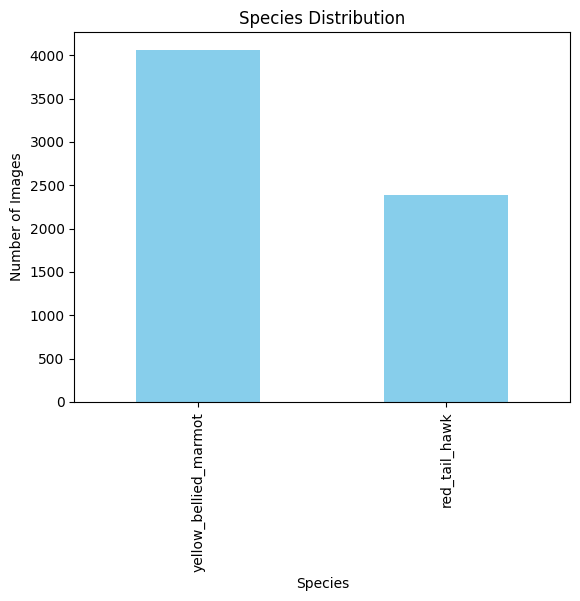

In [12]:
species_counts.plot(kind='bar', title='Species Distribution', color='skyblue')
plt.xlabel("Species")
plt.ylabel("Number of Images")
plt.show()

#### Image Resolution Check

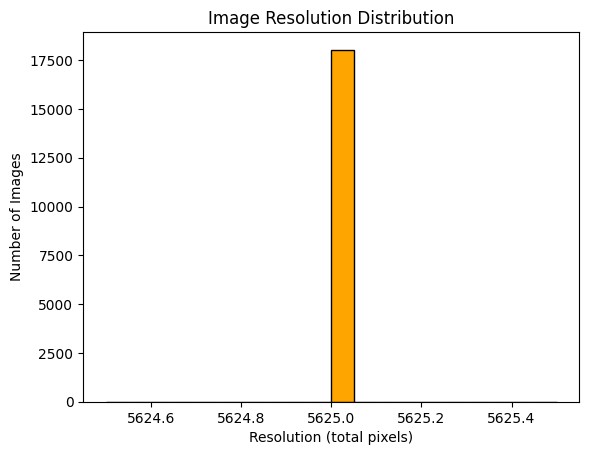

In [13]:
# Calculate total pixels (resolution) of each image
dimension_df['resolution'] = dimension_df['width'] * dimension_df['height']

# Plot histogram of resolutions
plt.hist(dimension_df['resolution'], bins=20, color='orange', edgecolor='black')
plt.title("Image Resolution Distribution")
plt.xlabel("Resolution (total pixels)")
plt.ylabel("Number of Images")
plt.show()

#### Visualize Sample Images

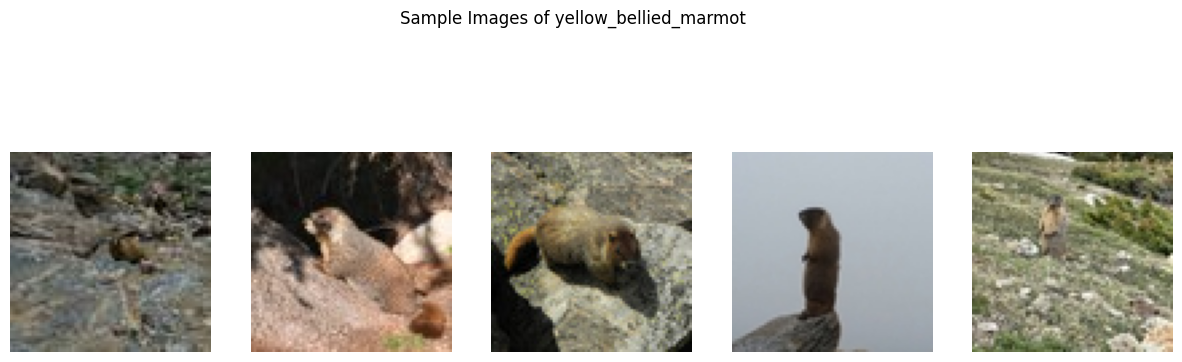

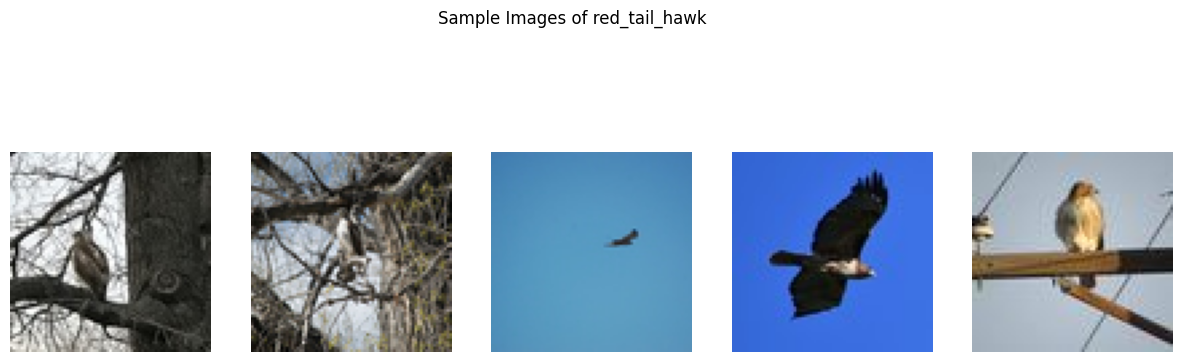

In [14]:
import random

def display_sample_images(df, species_name, sample_size=5):
    sample_df = df[df['common_name'] == species_name].sample(n=sample_size, random_state=42)
    fig, axes = plt.subplots(1, sample_size, figsize=(15, 5))
    fig.suptitle(f"Sample Images of {species_name}")
    
    for idx, (i, row) in enumerate(sample_df.iterrows()):
        img_path = f"species_images/{row['id']}.jpg"
        image = Image.open(img_path)
        axes[idx].imshow(image)
        axes[idx].axis("off")
    plt.show()

# Display sample images for each species
species_list = df['common_name'].unique()
for species in species_list:
    display_sample_images(df, species)

The images of the animals seem fairly clean and won't need much pre-processing. The classes are slightly imbalanced, with more marmots, but not enough to where it should cause significant issues in modeling. 

# Model Building

#### Load Images

In [24]:
import os
import pandas as pd

# Ensure 'id' in species_df is a string for consistent comparisons
species_df['id'] = species_df['id'].astype(str)

# Base directory for images
base_dir = 'species_images/'

# Create lists to hold image paths and labels
image_paths = []
labels = []

# Iterate through the image files in the directory
for img in os.listdir(base_dir):
    if img.endswith(('.png', '.jpg', '.jpeg')):  # Check for valid image files
        image_id = os.path.splitext(img)[0]  # Extract ID from the filename

        # Look up the common name (species) from species_df using the ID
        matching_row = species_df[species_df['id'] == image_id]
        if not matching_row.empty:
            inferred_label = matching_row['common_name'].iloc[0]

            # Add the image path and label to the lists
            full_path = os.path.join(base_dir, img)
            image_paths.append(full_path)
            labels.append(inferred_label)
        else:
            print(f"No match found for image ID: {image_id}")

# Convert to a DataFrame
data = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Display the first few entries
if data.empty:
    print("No data found! Ensure the images correspond to IDs in species_df.")
else:
    print(data.head())


No match found for image ID: 100006934.0
No match found for image ID: 100046972.0
No match found for image ID: 100082649.0
No match found for image ID: 100084652.0
No match found for image ID: 100086374.0
No match found for image ID: 100100127.0
No match found for image ID: 100144028.0
No match found for image ID: 100173696.0
No match found for image ID: 100176537.0
No match found for image ID: 100184521.0
No match found for image ID: 100192675.0
No match found for image ID: 100203480.0
No match found for image ID: 100203480
No match found for image ID: 100203482.0
No match found for image ID: 100203482
No match found for image ID: 100278519.0
No match found for image ID: 100337371.0
No match found for image ID: 100340845.0
No match found for image ID: 100342573.0
No match found for image ID: 100355392.0
No match found for image ID: 100377211.0
No match found for image ID: 100437848.0
No match found for image ID: 100441481.0
No match found for image ID: 100470602.0
No match found for i

#### Train/Test Split

In [26]:
train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)

#### Image Generators

In [27]:
# Set parameters
img_height, img_width = 150, 150  # Adjust based on your needs
batch_size = 32

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For testing set, we only rescale
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # Use 'binary' for binary classification
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)




Found 5161 validated image filenames belonging to 2 classes.
Found 1291 validated image filenames belonging to 2 classes.


#### Build Model

In [34]:
# Determine the number of classes from the generator
num_classes = len(train_generator.class_indices)

# Create a simple Convolutional Neural Network (CNN)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularization to prevent overfitting
    Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




#### Train Model

In [35]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,  # Adjust based on your needs
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    verbose=1
)


C:\Users\polin\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 48s 284ms/step - accuracy: 0.7573 - loss: 0.5239 - val_accuracy: 0.8656 - val_loss: 0.3346
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 1.0000 - loss: 0.1626 - val_accuracy: 0.9091 - val_loss: 0.3007
Epoch 3/20


c:\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


161/161 ━━━━━━━━━━━━━━━━━━━━ 53s 330ms/step - accuracy: 0.8451 - loss: 0.4087 - val_accuracy: 0.8742 - val_loss: 0.3441
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - accuracy: 0.9375 - loss: 0.2585 - val_accuracy: 0.8182 - val_loss: 0.3210
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 59s 366ms/step - accuracy: 0.8606 - loss: 0.3522 - val_accuracy: 0.8992 - val_loss: 0.2708
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.7188 - loss: 0.5272 - val_accuracy: 1.0000 - val_loss: 0.0671
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 59s 364ms/step - accuracy: 0.8739 - loss: 0.3126 - val_accuracy: 0.8930 - val_loss: 0.2612
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - accuracy: 0.9375 - loss: 0.2758 - val_accuracy: 0.8182 - val_loss: 0.4783
Epoch 9/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8740 - loss: 0.3268 - val_accuracy: 0.8875 - val_loss: 0.2816
Epoch 10/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - accuracy: 0.9688 - loss: 0.1685 - val_ac

#### Evaluate Model

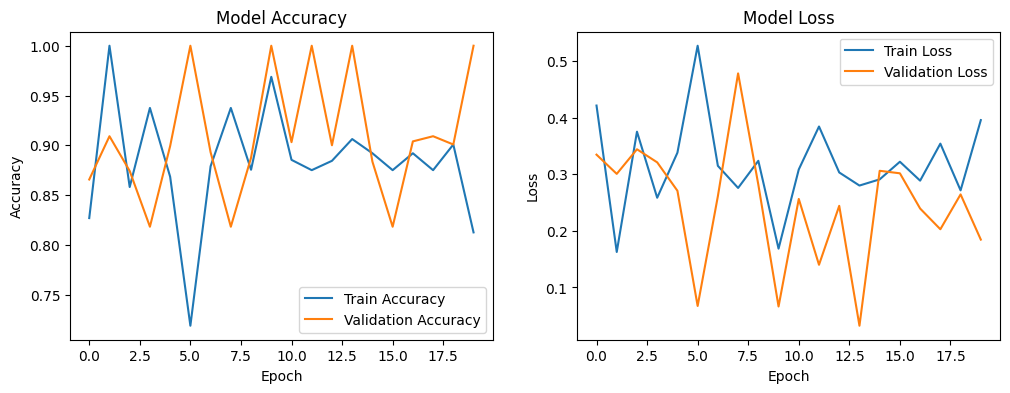

In [38]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


#### Predictions

In [41]:
def predict_image(img_path, model, img_height, img_width):
    # Load the image and resize it to the target size
    img = image.load_img(img_path, target_size=(img_height, img_width))
    
    # Convert the image to a numpy array and normalize it
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make a prediction
    prediction = model.predict(img_array)
    
    # Get the index of the highest probability
    class_index = np.argmax(prediction[0])
    
    # Get class labels from the generator
    class_labels = list(train_generator.class_indices.keys())  # Assumes you use the same generator
    
    # Return the predicted class label
    return class_labels[class_index]

In [42]:
def predict_for_test_images(test_df, model, img_height, img_width):
    predictions = []
    
    for _, row in test_df.iterrows():
        img_path = row['image_path']
        predicted_class = predict_image(img_path, model, img_height, img_width)
        predictions.append(predicted_class)
        
    return predictions

# Get predictions for all test images
test_predictions = predict_for_test_images(test_df, model, img_height, img_width)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

In [47]:
test_df['pred'] = test_predictions
test_df.head()

,image_path,label,pred
6217,species_images/91196949.jpg,yellow_bellied_marmot,yellow_bellied_marmot
1250,species_images/170046641.jpg,yellow_bellied_marmot,yellow_bellied_marmot
4634,species_images/53630798.jpg,red_tail_hawk,red_tail_hawk
5966,species_images/86246651.jpg,yellow_bellied_marmot,yellow_bellied_marmot
1665,species_images/179943913.jpg,yellow_bellied_marmot,yellow_bellied_marmot


### Evaluate

In [52]:
def plot_confusion_matrix(true_labels, predicted_labels, class_labels):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Create heatmap for confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels, 
                cbar=False, linewidths=0.5, linecolor='black')

    # Add labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

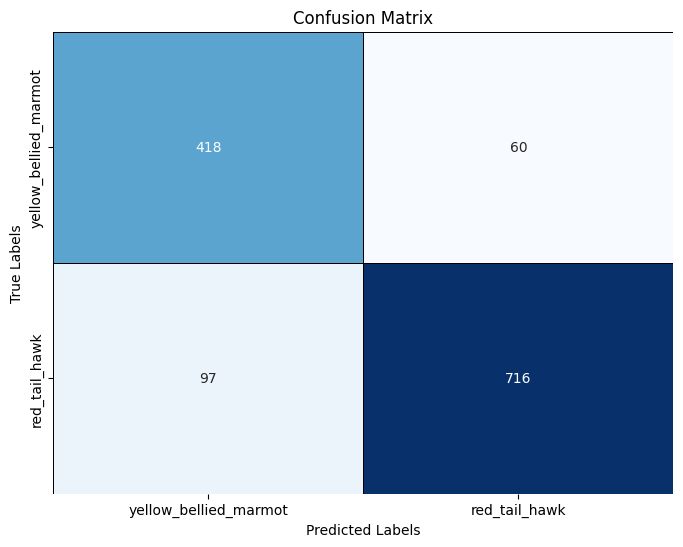

In [60]:
class_labels = ['yellow_bellied_marmot', 'red_tail_hawk']

true_labels = test_df['label']
predictions = test_df['pred']

plot_confusion_matrix(true_labels, predictions, class_labels)

In [62]:
precision = precision_score(true_labels, predictions, average='macro')  
recall = recall_score(true_labels, predictions, average='macro')  
accuracy = accuracy_score(true_labels, predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.8672
Recall: 0.8776
Accuracy: 0.8784


### Discussion

The CNN Model performs fairly well in being able to classify pictures of marmots and hawks. With a near 88% accuracy, one could reliable use this model to classify these two animals seen in the wild or in trail cameras.

In future iterations I would like to include more animals to see how well the model can generalize to having to classify more than just two animals. Another future improvement could be including multiple states in the classification model to see how well it generalizes to observations of the same species across several geographic regions.

From a technical perspective, the model may benefit from trying out different architectures and additional hyperparameter tuning.